In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Load the satellite dataset.
tiny_satellite_dir = 'data'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

def get_TINYSAT_data(root_path, split):
    # Get the training dataset!
    split_dir = os.path.join(root_path, split)
    filenames = os.listdir(split_dir)
    filenames = [os.path.join(split_dir, f) for f in filenames if f.endswith('.jpg')] 
    
    labels = [int(os.path.split(f)[-1][0]) for f in filenames]
    images = [np.asarray(Image.open(f).resize((64, 64), Image.BILINEAR)) for f in filenames]
    
    X_train = np.array(images)
    y_train = np.array(labels)
    
    return X_train, y_train

X_train, y_train = get_TINYSAT_data(tiny_satellite_dir, "train")
X_test, y_test = get_TINYSAT_data(tiny_satellite_dir, "val")

# Save for later analysis
orig_X_train = X_train
orig_X_test = X_test

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (234, 64, 64, 3)
Training labels shape:  (234,)
Test data shape:  (17, 64, 64, 3)
Test labels shape:  (17,)


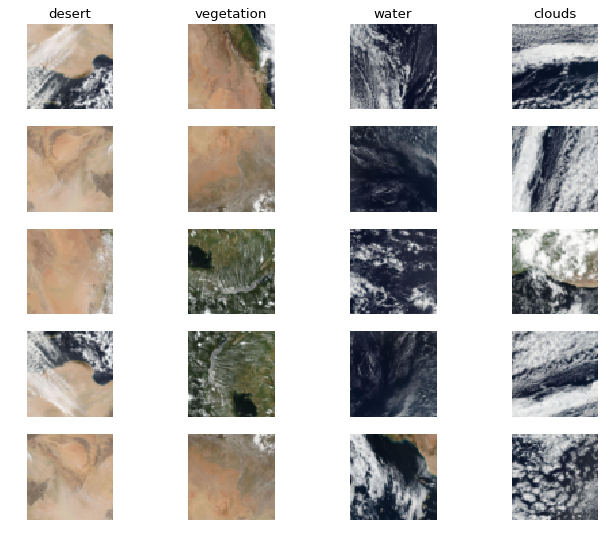

In [92]:
# Visualize some examples from the training dataset.
# We show a few examples of training images from each class.
classes = ['desert', 'vegetation', 'water', 'clouds']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [123]:
from features import *

num_color_bins = 4 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_test_feats -= mean_feat

# # Preprocessing: Divide by standard deviation. This ensures that each feature
# # has roughly the same scale.
# std_feat = np.std(X_train_feats, axis=0, keepdims=True)
# X_train_feats /= std_feat
# X_test_feats /= std_feat

print(X_train_feats.shape, X_test_feats.shape)

(234, 580) (17, 580)


In [124]:
from models.knn import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train_feats, y_train)

In [125]:
# Test your implementation:
dists = classifier.compute_distances(X_test_feats)
print(dists.shape)

(17, 234)


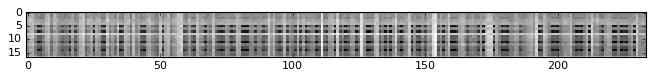

In [126]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples. Note that with the default color scheme 
# black indicates low distances while white indicates high distances.)
plt.imshow(dists, interpolation='none')
plt.show()

In [127]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_test = len(X_test_feats)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 14 / 17 correct => accuracy: 0.823529


In [128]:
y_test_pred = classifier.predict_labels(dists, k=2)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 9 / 17 correct => accuracy: 0.529412


In [135]:
num_folds = 5
k_choices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
################################################################################
X_train_folds = np.array_split(X_train_feats, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:    
    fold_accuracies = []
    for fold in range(num_folds): 
        # Create the fold splits
        X_train_temp = np.concatenate(X_train_folds[:fold] + X_train_folds[fold+1:])
        y_train_temp = np.concatenate(y_train_folds[:fold] + y_train_folds[fold+1:])
        X_test_temp = X_train_folds[fold]
        y_test_temp = y_train_folds[fold]
        
        # Create the k-nearest-neighbors algorithm
        classifier_temp = KNearestNeighbor()
        classifier_temp.train(X_train_temp, y_train_temp)
        
        # Compute the distance and accuracy
        dists_temp = classifier_temp.compute_distances(X_test_temp)
        y_test_pred_temp = classifier_temp.predict_labels(dists_temp, k)
        num_correct_temp = np.sum(y_test_pred_temp == y_test_temp)
        num_test_temp = X_test_temp.shape[0]
        accuracy_temp = float(num_correct_temp) / num_test_temp
        
        # Add to the accuracies for each fold
        fold_accuracies.append(accuracy_temp)
    k_to_accuracies[k] = fold_accuracies

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.191489
k = 1, accuracy = 0.510638
k = 1, accuracy = 0.446809
k = 1, accuracy = 0.553191
k = 1, accuracy = 0.543478
k = 2, accuracy = 0.170213
k = 2, accuracy = 0.382979
k = 2, accuracy = 0.382979
k = 2, accuracy = 0.510638
k = 2, accuracy = 0.521739
k = 3, accuracy = 0.191489
k = 3, accuracy = 0.510638
k = 3, accuracy = 0.404255
k = 3, accuracy = 0.510638
k = 3, accuracy = 0.586957
k = 4, accuracy = 0.148936
k = 4, accuracy = 0.468085
k = 4, accuracy = 0.382979
k = 4, accuracy = 0.446809
k = 4, accuracy = 0.500000
k = 5, accuracy = 0.191489
k = 5, accuracy = 0.510638
k = 5, accuracy = 0.319149
k = 5, accuracy = 0.489362
k = 5, accuracy = 0.521739
k = 6, accuracy = 0.170213
k = 6, accuracy = 0.510638
k = 6, accuracy = 0.361702
k = 6, accuracy = 0.468085
k = 6, accuracy = 0.565217
k = 7, accuracy = 0.191489
k = 7, accuracy = 0.510638
k = 7, accuracy = 0.382979
k = 7, accuracy = 0.489362
k = 7, accuracy = 0.521739
k = 8, accuracy = 0.170213
k = 8, accuracy = 0.468085
k

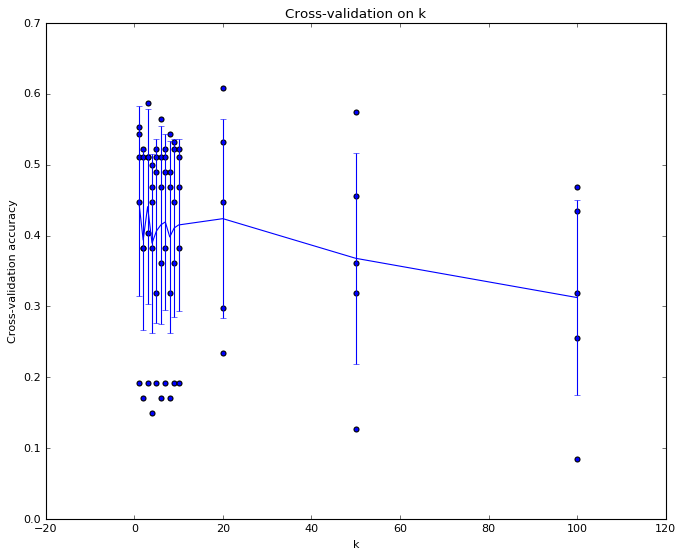

In [136]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [137]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.
best_k = k_choices[np.argmax(accuracies_mean)]

classifier = KNearestNeighbor()
classifier.train(X_train_feats, y_train)
y_test_pred = classifier.predict(X_test_feats, k=best_k).astype(int)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Best k = %d' % best_k)
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Best k = 1
Got 14 / 17 correct => accuracy: 0.823529


In [138]:
# Generate confusion matrix
# - results = list of tuples of (correct label, predicted label)
# - categories = list of category names
# Returns confusion matrix; rows are correct labels and columns are predictions
def confusion_matrix(results, categories, plotConfusion=False):
    # Empty confusion matrix
    matrix = np.zeros((len(categories),len(categories)))

    # Iterate over all labels and populate matrix
    for label, pred in results:
        matrix[label, pred] += 1

    # Print matrix and percent accuracy
    accuracy = float(np.trace(matrix)) * 100.0 / len(results)
    print('Accuracy: ' +  str(accuracy) + '%')

    # Normalize confusion matrix
    normalizeMatrix = True
    if normalizeMatrix:
      print("utility.confusion_matrix(). Non-normalized conf_mat:")
      print(matrix)
      s = np.sum(matrix,1) # Sum each row
      for i in range(matrix.shape[0]):
        # Normalization handles class imbalance in training set
        matrix[i,:] /= s[i]

    # Save matrix to file:
    # np.save("confusion_matrix.npy", matrix)

    # Plot the confusion matrix
    if plotConfusion:
        plot_confusion_matrix(matrix, categories)

def plot_confusion_matrix(cm, names=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(4)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add labels to confusion matrix:
    if names is None:
        names = range(cm.shape[0])

    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy: 82.3529411765%
utility.confusion_matrix(). Non-normalized conf_mat:
[[6. 0. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 2. 0.]
 [1. 0. 1. 5.]]


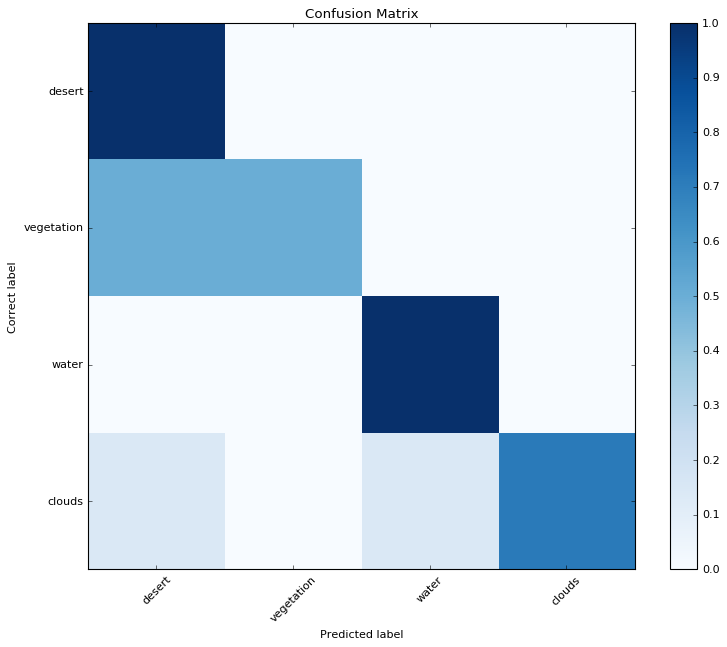

In [139]:
confusion_matrix(zip(y_test, y_test_pred), classes, plotConfusion=True)

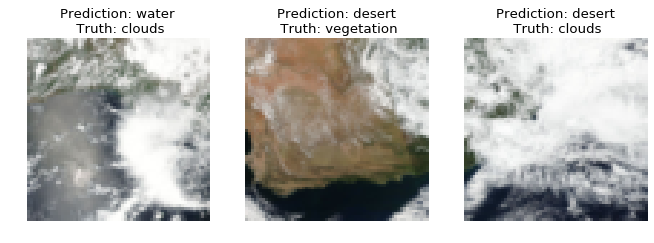

In [140]:
# Visualize misclassified examples from the test dataset.
classes = ['desert', 'vegetation', 'water', 'clouds']
num_classes = len(classes)
max_examples = 4

incorrect_idx = [idx for idx, incorrect in enumerate(y_test != y_test_pred) if incorrect]
if len(incorrect_idx) > max_examples:
    incorrect_idx = incorrect_idx[:max_examples]
num_incorrect = len(incorrect_idx)

for y, idx in enumerate(incorrect_idx):
    for i in range(1):
        plt_idx = i * num_incorrect + y + 1
        plt.subplot(2, num_incorrect, plt_idx)
        plt.imshow(orig_X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title("Prediction: %s\n Truth: %s" % (classes[y_test_pred[idx]], classes[y_test[idx]]))
plt.show()